## KNN DTW clustering

Here we run KNN clustering with Dynamic Time Warping distace.

We cant run this on the entire half hourly dataset as when I tried this the clustering code used >500GB RAM

We run this on one week of half hourly data, as well as 12 weeks of daily data

In [1]:
import sys, os, copy, random, time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
PATH='../input/merged_data/'

In [5]:
# These are the usual ipython objects
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

## Daily data

In [6]:
df = pd.read_csv('{0}daily_for_clustering.csv'.format(PATH))

In [7]:
df.head()

,Unnamed: 0,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,day_count
0,0,MAC000118,2012-08-01,0.0910,0.112188,0.270,48,0.053445,5.385,0.058,0.0
1,1,MAC000118,2012-08-02,0.0910,0.118250,0.408,48,0.069946,5.676,0.062,1.0
2,2,MAC000118,2012-08-03,0.1195,0.143250,0.486,48,0.091924,6.876,0.060,2.0
3,3,MAC000118,2012-08-04,0.1135,0.164583,0.509,48,0.121292,7.900,0.060,3.0
4,4,MAC000118,2012-08-05,0.1390,0.210625,0.869,48,0.161252,10.110,0.081,4.0


In [8]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [9]:
df_stats = df.groupby(['LCLid']).agg({'energy_median': ['mean'], 'energy_sum': ['mean']})

In [10]:
df_stats.head()

,energy_sum,energy_median
,mean,mean
LCLid,,
MAC000002,12.096094,0.186374
MAC000003,20.316226,0.168294
MAC000004,1.722252,0.000346
MAC000005,4.649915,0.051459
MAC000006,2.873562,0.049154


In [11]:
df_count = df.groupby(['LCLid']).size().reset_index(name='counts')

In [12]:
df_count.head()

,LCLid,counts
0,MAC000002,498
1,MAC000003,574
2,MAC000004,575
3,MAC000005,574
4,MAC000006,573


/home/walle/.virtualenvs/datascience/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


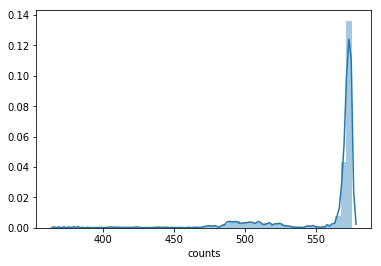

In [13]:
sns.distplot(df_count['counts'])

In [14]:
df['day'] = pd.to_datetime(df['day'], format='%Y-%m-%d')

In [15]:
df.dtypes

LCLid                    object
day              datetime64[ns]
energy_median           float64
energy_mean             float64
energy_max              float64
energy_count              int64
energy_std              float64
energy_sum              float64
energy_min              float64
day_count               float64
dtype: object

In [16]:
# visualize the data windows
num_to_plot = 100

rng = np.random.RandomState(seed=100)
mac_to_plot = rng.choice(df_count['LCLid'], num_to_plot)

In [17]:
mac_to_plot[:5]

array(['MAC004145', 'MAC000086', 'MAC000372', 'MAC002011', 'MAC004375'],
      dtype=object)

Randowm selection of data range from 100 households 

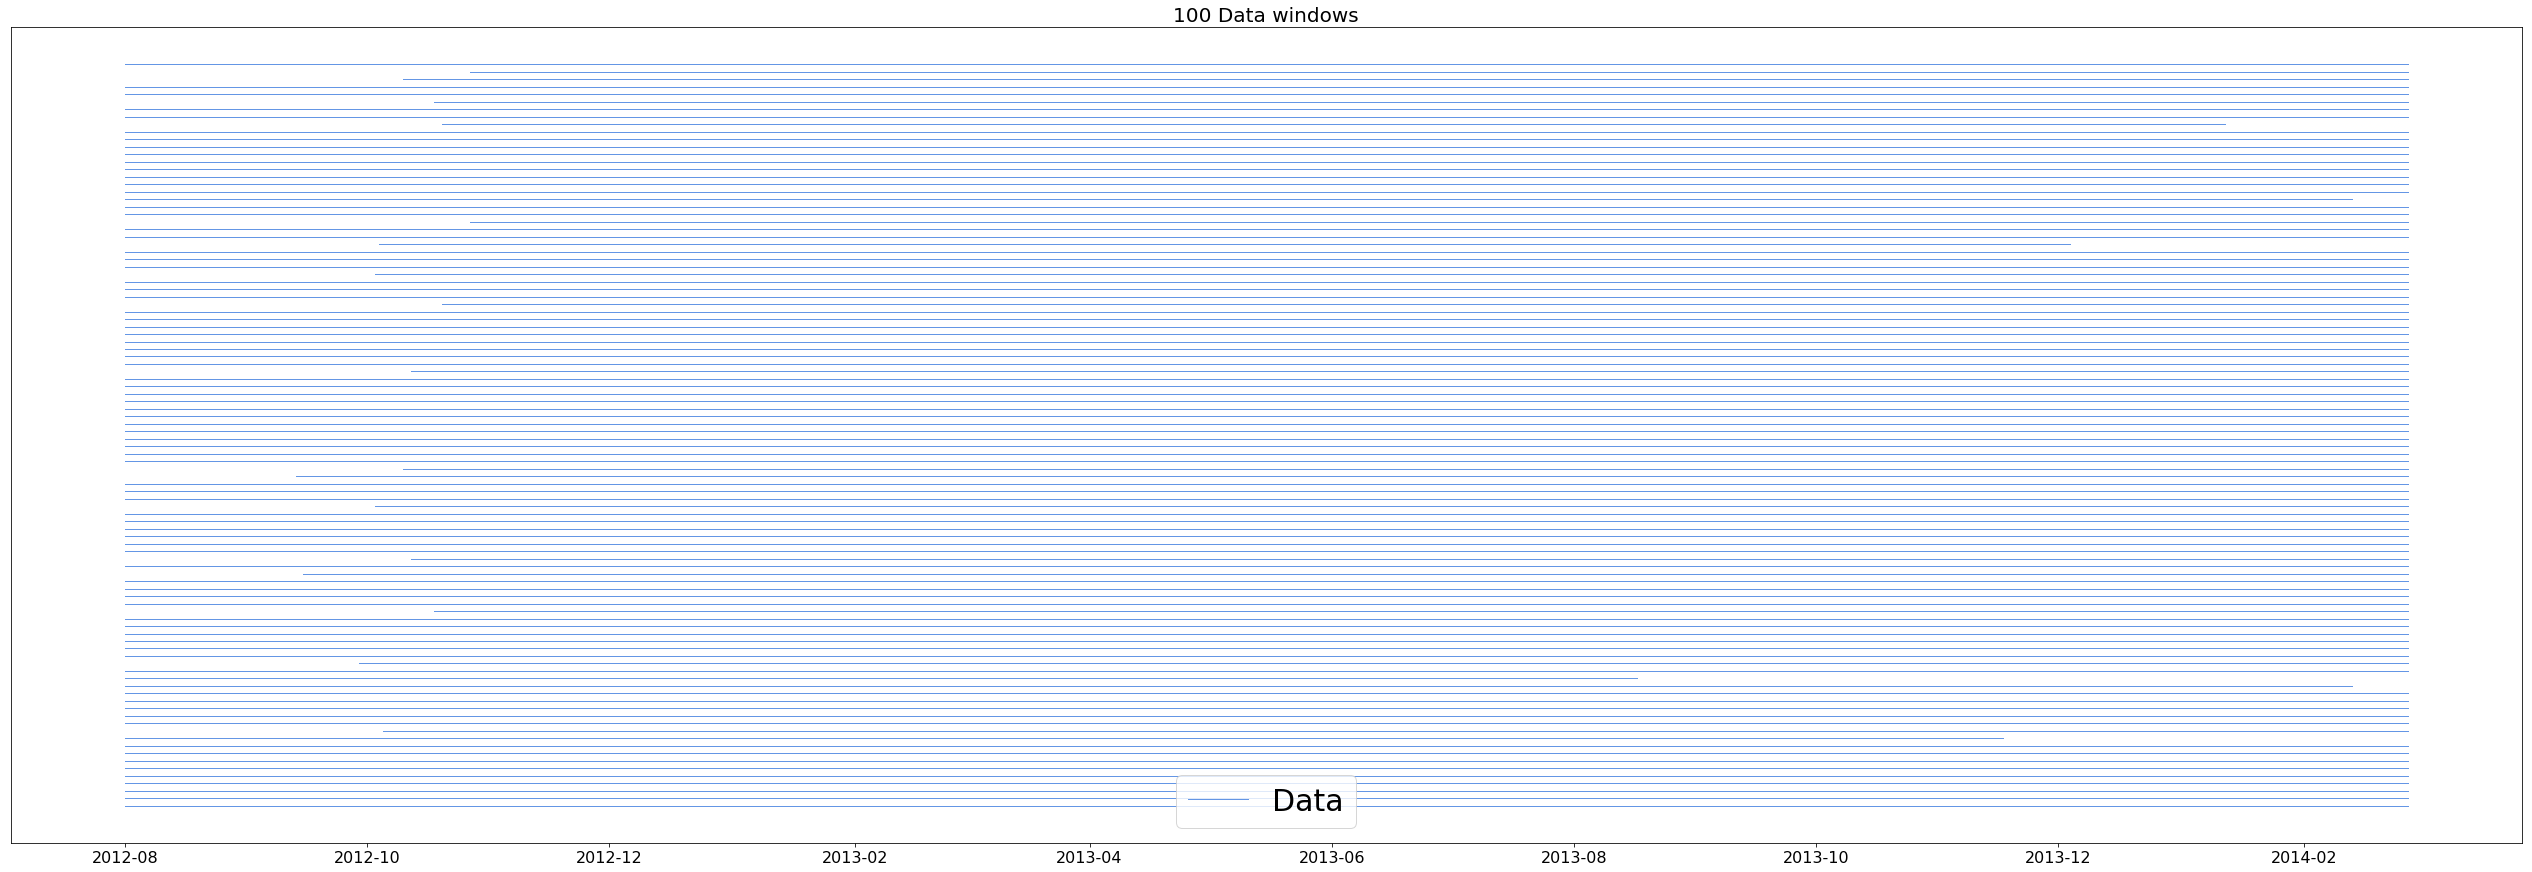

In [18]:

fig, ax = plt.subplots(figsize=(45, 15))

for i, mac in enumerate(mac_to_plot):
    #mac_data = mac['energy_sum']
    mac_df = df.loc[df['LCLid'] == mac]
    mac_start = mac_df['day'].min()
    mac_end = mac_df['day'].max()
    
    ax.plot([mac_start, mac_end], [i, i], c='#6496e5', linewidth=1)

# the y tick labels don't mean anything so turn them off
ax.set_yticks([])
plt.tick_params(labelsize=16)
plt.legend(['Data'], 
           fontsize=30)

plt.title('{0} Data windows'.format(num_to_plot), fontsize=20);

Narrow the range some more

In [19]:
start_date=datetime.datetime(year=2013,month=1,day=1)
end_date=datetime.datetime(year=2013,month=12,day=31)

In [20]:
# Data subset
df_subset=df[(df["day"]>=start_date) & (df["day"]<end_date)]

In [21]:
df_subset_count = df_subset.groupby(['LCLid']).size().reset_index(name='counts')

In [22]:
df_subset_count.head()

,LCLid,counts
0,MAC000002,364
1,MAC000003,362
2,MAC000004,363
3,MAC000005,363
4,MAC000006,364


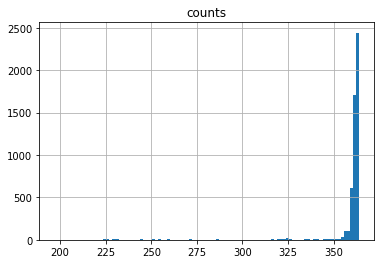

In [23]:
hist = df_subset_count.hist(bins=100)


In [24]:
cluster_dataset=df_subset_count.loc[df_subset_count['counts'] > 350]

In [25]:
cluster_dataset.head()

,LCLid,counts
0,MAC000002,364
1,MAC000003,362
2,MAC000004,363
3,MAC000005,363
4,MAC000006,364


In [26]:
cluster_df = df_subset.loc[df_subset['LCLid'].isin(cluster_dataset['LCLid'])]

/home/walle/.virtualenvs/datascience/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


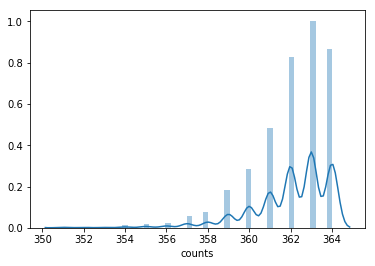

In [27]:
count = cluster_df.groupby(['LCLid']).size().reset_index(name='counts')
sns.distplot(count['counts'])

In [28]:
len(cluster_df)

1820183

In [29]:
df_subset.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,day_count
152,MAC000118,2013-01-01,0.1355,0.140250,0.346,48,0.072628,6.732,0.060,153.0
153,MAC000118,2013-01-02,0.0970,0.130729,0.377,48,0.077881,6.275,0.053,154.0
154,MAC000118,2013-01-03,0.0855,0.153250,0.744,48,0.152709,7.356,0.056,155.0
155,MAC000118,2013-01-04,0.0915,0.137313,0.591,48,0.099288,6.591,0.061,156.0
156,MAC000118,2013-01-05,0.1380,0.147708,0.375,48,0.085482,7.090,0.058,157.0


In [30]:
df_date_count = df_subset.groupby(['day']).size().reset_index(name='counts')

In [31]:
df_date_count.head()

,day,counts
0,2013-01-01,5259
1,2013-01-02,5263
2,2013-01-03,5261
3,2013-01-04,5245
4,2013-01-05,5255


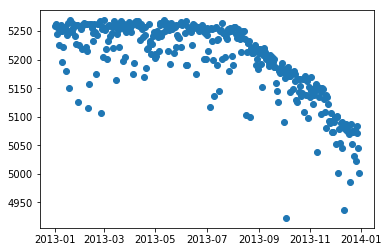

In [32]:
plt.plot_date(df_date_count['day'],df_date_count['counts'])

We can either cluser data accross a wider date range with less households, or a narrower date range with more households.

Lets just pick those households with data spanning from 2013-01-01 to 2013-09-01

In [33]:
start_date=datetime.datetime(year=2013,month=1,day=1)
end_date=datetime.datetime(year=2013,month=9,day=1)

In [35]:
# Data subset
mask= (df['day'] > start_date) & (df['day'] <= end_date)

In [36]:
df = df.loc[mask]

In [37]:
df_date_count = df.groupby(['day']).size().reset_index(name='counts')

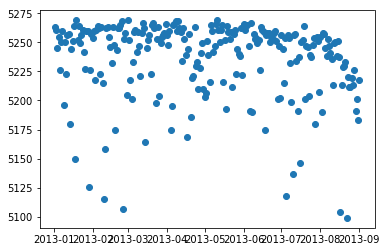

In [38]:
plt.plot_date(df_date_count['day'],df_date_count['counts'])

### Save clustering dataset

In [40]:
df.to_csv('{0}nine_month_cluster_data.csv'.format(PATH))

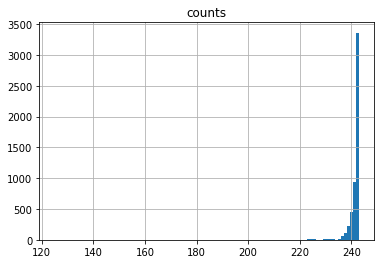

In [41]:
df_count = df.groupby(['LCLid']).size().reset_index(name='counts')
hist = df_count.hist(bins=100)

In [ ]:
# convert data to list of lists for clustering
energy_sum = df.groupby('LCLid', sort=False)['energy_sum'].apply(list).values.tolist()
energy_mean = df.groupby('LCLid', sort=False)['energy_mean'].apply(list).values.tolist()


We re-visited this notebook after generting a consitently sampled dataset with consistent start/end and number of samples accross all houselds in notebook 1_5_data_wrangling...

We now import and plot this data

### Dynamic Time Warping

see https://github.com/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb

In [6]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [7]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

### kNN clustering

using kNN algoritm with a dynamic time warping similarity measure.

In [8]:
def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        #print ind
        for j in train:
            if LB_Keogh(i[:-1],j[:-1],5)<min_dist:
                dist=DTWDistance(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return classification_report(test[:,-1],preds)

In [9]:
def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(list(data),num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print (counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids


## Read in half-hourly data

In [8]:
df = pd.read_csv(f'{PATH}hh_for_clustering_544_ids_735_days.csv')

In [9]:
df.head(n=2)

,Unnamed: 0,day_time,LCLid,energy(kWh/hh),dayElapsed,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
0,0,2012-02-05 00:00:00,MAC000006,0.042,1328400000,1.32,160.0,-0.12,-0.22,1024.21,-4.68,4.35,0.99
1,1,2012-02-05 00:00:00,MAC005178,0.561,1328400000,1.32,160.0,-0.12,-0.22,1024.21,-4.68,4.35,0.99


In [10]:
ts = df['energy(kWh/hh)'].values

### Run clustering

NB memory intensive

In [ ]:
#totally arbitrary value, TODO use elbow method and various k
num_clust = 20
centroids=k_means_clust(ts,num_clust,10,4)

### Plot results

In [ ]:
for i in centroids:
    plt.plot(i)

plt.show()